[![Github](https://img.shields.io/github/stars/lab-ml/labml?style=social)](https://github.com/labmlai/labml)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/labmlai/labml/blob/master/guides/model_probe.ipynb)

## Probing a model to extract attentions

This is a short demo of [`ModelProbe` API](https://docs.labml.ai/api/analytics.html#labml.analytics.ModelProbe). You can wrap any PyTorch model with `ModelProbe` to extract parameters of the model, outputs and inputs of all layers as well as gradients.

We use pre-trained `bert-base-uncased` model from [Huggingface transformers](https://github.com/huggingface/transformers) for this demo.

*Note that Huggingface transformer model have an option to extract attentions by setting `output_attentions=True`. We will not use this in this demo to show the general case where such an option is not available, to extract sub-layer outputs.*

In [1]:
# Install transformers and labml
%%capture
!pip install transformers labml

In [2]:
# Imports
from transformers import BertTokenizer, BertModel
from labml.logger import inspect
import torch
import torch.nn
import numpy as np
from labml.analytics import ModelProbe
import math
from matplotlib import pyplot as plt

In [3]:
# Load model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [4]:
# Tokenize the input text
inputs = tokenizer.encode("Let's see how attention works.")
tokens = tokenizer.convert_ids_to_tokens(inputs)
inspect(tokens)

In [5]:
# Wrap the model
probe = ModelProbe(model)

#### Extract parameters

You can extract parameters from `probe.parameters`. You can filter parameters with any wildcard string.

Similar to layer inputs/outputs shown below you can get the parameter values with `get_list` or `get_dict` functions.

In [6]:
inspect(probe.parameters['*attention*'])

In [8]:
# Evaluate the model
res = model(torch.tensor([inputs]))
inspect(res)

#### Extract layer inputs/outputs

You can extract layer inputs with `foward_input` or layer outputs with `forward_output`. Just like parameters you can filter the layers with a wildcard string.

The function `deep` will expand the input and output values further if they are tuples, lists or dictionaries so that we can quickly filter those deep structures. This is useful in layer inputs since all of them are tuples.

In [9]:
inspect(probe.forward_input['*attention*'].deep())

The attention matrix of each layer is given as input to the dropout layer.

Here's the [huggingface/transformers model implementation that does it](https://github.com/huggingface/transformers/blob/master/src/transformers/models/bert/modeling_bert.py#L334).

So we will filter the inputs to the dropout and capture the attentions.

In [10]:
attn_dropout_inputs = probe.forward_input.deep()['*.attention.self.dropout/0']
inspect(attn_dropout_inputs)

`get_list` returns the filtered objects as a list. Lets examine the attention matrix of the first layer.

The shape `[1, 12, 10, 10]` is for batch, head, sequence length, and sequence length.

In [11]:
inspect(attn_dropout_inputs.get_list()[0])

We will get attention matrices for each layer and stack them


In [12]:
# Remove the batch dimension and detach the attention matrices 
attn = [a[0].detach() for a in attn_dropout_inputs.get_list()]
# Stack them
attn = torch.stack(attn)
inspect(attn)

This is a simple visualization of attention matrices of some layers (first four) and some heads (first four).

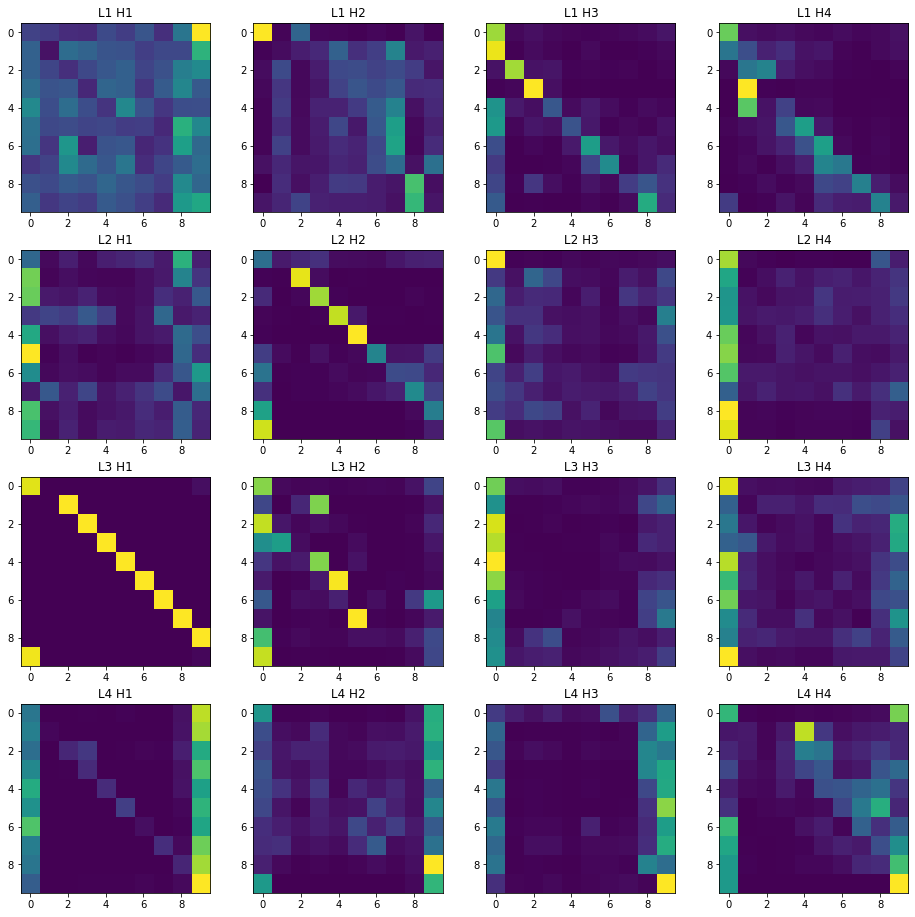

In [15]:
# Plot 4 layers and 4 heads of each layer
n_layers, n_heads = 4, 4
# Create subplots
fig, ax = plt.subplots(n_layers, n_heads, figsize=(n_heads * 4, n_layers * 4))
for r in range(n_layers):
    for c in range(n_heads):
        # Plot the matrix
        ax[r][c].imshow(attn[r][c], vmin=0)
        ax[r][c].set_title(f"L{r + 1} H{c + 1}")
plt.show()